In [1]:
!pip3 install gym pyvirtualdisplay
!sudo apt-get install -y xvfb python-opengl ffmpeg

!pip3 install --upgrade setuptools --user
!pip3 install ez_setup 

!pip3 install gym[atari] 

!pip install -q autorom[accept-rom-license]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
The following additional packages will be installed:
  freeglut3 libfontenc1 libpython2-stdlib libxfont2 libxkbfile1 python2
  python2-minimal x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
Suggested packages:
  python-tk python-numpy libgle3 python2-doc
The following NEW packages will be installed:
  freeglut3 libfontenc1 libpython2-stdlib libxfont2 libxkbfile1 python-opengl
  python2 python2-minimal x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 14 newly installed, 0 to remove and 24 not upgraded.
Need to get 8,318 kB of archives.
After this operation, 18.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 python2-m

In [2]:
!mkdir save_graph
!mkdir save_model
%matplotlib inline

import os
import sys
import gym
import torch
import pylab
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from datetime import datetime
from copy import deepcopy
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from skimage.transform import resize
from skimage.color import rgb2gray


# Hyperparameters for DQN agent, memory and training
EPISODES = 3500
HEIGHT = 84
WIDTH = 84
HISTORY_SIZE = 4
learning_rate = 0.0001
evaluation_reward_length = 100
Memory_capacity = 1000000
train_frame = 100000
batch_size = 32
scheduler_gamma = 0.4
scheduler_step_size = 100000

# Hyperparameters for Double DQN agent
update_target_network_frequency = 1000


class DQN(nn.Module):
    def __init__(self, action_size):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc = nn.Linear(3136, 512)
        self.head = nn.Linear(512, action_size)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.fc(x.view(x.size(0), -1)))
        return self.head(x)


def find_max_lives(env):
    env.reset()
    _, _, _, info = env.step(0)
    return info['lives']

def check_live(life, cur_life):
    if life > cur_life:
        return True
    else:
        return False

def get_frame(X):
    x = np.uint8(resize(rgb2gray(X), (HEIGHT, WIDTH), mode='reflect') * 255)
    return x

def get_init_state(history, s):
    for i in range(HISTORY_SIZE):
        history[i, :, :] = get_frame(s)


class ReplayMemory(object):
    def __init__(self):
        self.memory = deque(maxlen=Memory_capacity)
    
    def push(self, history, action, reward, done):
        if torch.is_tensor(action):
          action = action.cpu()
          
        self.memory.append((history, action, reward, done))

    def sample_mini_batch(self, frame):
        mini_batch = []
        if frame >= Memory_capacity:
            sample_range = Memory_capacity
        else:
            sample_range = frame

        sample_range -= (HISTORY_SIZE + 1)

        idx_sample = random.sample(range(sample_range), batch_size)
        for i in idx_sample:
            sample = []
            for j in range(HISTORY_SIZE + 1):
                sample.append(self.memory[i + j])

            sample = np.array(sample)
            mini_batch.append((np.stack(sample[:, 0], axis=0), sample[3, 1], sample[3, 2], sample[3, 3]))

        return mini_batch

    def __len__(self):
        return len(self.memory)

In [3]:
import gym
env = gym.make('BreakoutDeterministic-v4')
state = env.reset()


number_lives = find_max_lives(env)
state_size = env.observation_space.shape
action_size = 3 #fire, left, and right


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/uti

In [13]:
class Agent():
    def __init__(self, action_size):
        self.action_size = action_size

        # These are hyper parameters for the DQN
        self.discount_factor = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.explore_step = 500000
        self.epsilon_decay = (self.epsilon - self.epsilon_min) / self.explore_step
        self.train_start = 100000
        self.update_target = 1000

        # Generate the memory
        self.memory = ReplayMemory()

        # Create the policy net and the target net
        self.policy_net = DQN(action_size)
        self.policy_net.to(device)
        self.target_net = DQN(action_size)
        self.target_net.to(device)
        
        self.optimizer = optim.Adam(params=self.policy_net.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

        # Initialize a target network and initialize the target network to the policy net
        self.update_target_net()

    def load_policy_net(self, path):
        self.policy_net = torch.load(path)           

    # after some time interval update the target net to be same with policy net
    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    """Get action using policy net using epsilon-greedy policy"""
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            temp = []
            random_number = random.randrange(self.action_size)
            temp.append([random_number])
            return torch.tensor(temp, device=device, dtype=torch.long)
        else:
            with torch.no_grad():
                state_tensor = torch.tensor([state], device=device)
                q_values = self.policy_net(state_tensor)
                action = q_values.argmax().item()
            return torch.tensor([[action]], device=device, dtype=torch.long)


    def train_policy_net(self, frame):
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay

        mini_batch = self.memory.sample_mini_batch(frame)
        mini_batch = np.array(mini_batch).transpose()

        history = np.stack(mini_batch[0], axis=0)
        states = np.float32(history[:, :4, :, :]) / 255.
        states = torch.from_numpy(states).cuda()
        actions = list(mini_batch[1])
        actions = torch.LongTensor(actions).cuda()
        rewards = list(mini_batch[2])
        rewards = torch.FloatTensor(rewards).cuda()
        next_states = np.float32(history[:, 1:, :, :]) / 255.
        next_states = torch.tensor(next_states).cuda()

        dones = mini_batch[3] # checks if the game is over
        musk = torch.tensor(list(map(int, dones==False)),dtype=torch.bool)
        
        # Compute Q(s_t, a), the Q-value of the current state
        state_action_values = self.policy_net(states)[range(batch_size), actions.view(batch_size).long()]

        # Compute Q function of next state
        next_state_values = torch.zeros(batch_size, device=device)
        temp = [s is not None for s in next_states]
        non_final_mask = torch.tensor(temp, device=device, dtype=torch.bool)
        temp2 = [s for s in next_states if s is not None]
        non_final_ns = torch.stack(temp2).to(device)

        # Find maximum Q-value of action at next state from policy net
        next_state_values[non_final_mask] = self.target_net(non_final_ns).max(1)[0].detach()


        next_mul_discount = next_state_values * self.discount_factor
        expected_value =  next_mul_discount + rewards
        reshaped_state_action_value = state_action_values.view(32)

        # Compute the Huber Loss
        loss = F.smooth_l1_loss(reshaped_state_action_value, expected_value)

        self.optimizer.zero_grad()
        loss.backward()

        # Optimize the model, .step() both the optimizer and the scheduler!
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()


## Creating a DQN Agent

Here we create a DQN Agent. This agent is defined in the __agent.py__. The corresponding neural network is defined in the __model.py__. Once you've created a working DQN agent, use the code in agent.py to create a double DQN agent in __agent_double.py__. Set the flag "double_dqn" to True to train the double DQN agent.

__Evaluation Reward__ : The average reward received in the past 100 episodes/games.

__Frame__ : Number of frames processed in total.

__Memory Size__ : The current size of the replay memory.

In [5]:
double_dqn = True 

agent = Agent(action_size)


evaluation_reward = deque(maxlen=evaluation_reward_length)
frame = 0
memory_size = 0

### Main Training Loop

In this training loop, we do not render the screen because it slows down training signficantly. To watch the agent play the game, run the code in next section "Visualize Agent Performance"

episode: 0   score: 1.0   memory length: 152   epsilon: 1.0    steps: 152    lr: 0.0001     evaluation reward: 1.0
episode: 1   score: 0.0   memory length: 276   epsilon: 1.0    steps: 124    lr: 0.0001     evaluation reward: 0.5
episode: 2   score: 2.0   memory length: 495   epsilon: 1.0    steps: 219    lr: 0.0001     evaluation reward: 1.0
episode: 3   score: 0.0   memory length: 619   epsilon: 1.0    steps: 124    lr: 0.0001     evaluation reward: 0.75
episode: 4   score: 2.0   memory length: 817   epsilon: 1.0    steps: 198    lr: 0.0001     evaluation reward: 1.0
episode: 5   score: 2.0   memory length: 1019   epsilon: 1.0    steps: 202    lr: 0.0001     evaluation reward: 1.1666666666666667
episode: 6   score: 2.0   memory length: 1218   epsilon: 1.0    steps: 199    lr: 0.0001     evaluation reward: 1.2857142857142858
episode: 7   score: 0.0   memory length: 1342   epsilon: 1.0    steps: 124    lr: 0.0001     evaluation reward: 1.125
episode: 8   score: 1.0   memory length: 151

<ipython-input-2-fe06b66ed4ea>:108: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  sample = np.array(sample)
<ipython-input-2-fe06b66ed4ea>:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample = np.array(sample)
<ipython-input-4-70fb2ca04b55>:56: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`_

episode: 549   score: 1.0   memory length: 100136   epsilon: 0.9997287400000059    steps: 170    lr: 0.0001     evaluation reward: 1.44
episode: 550   score: 4.0   memory length: 100454   epsilon: 0.9990991000000196    steps: 318    lr: 0.0001     evaluation reward: 1.47
episode: 551   score: 1.0   memory length: 100625   epsilon: 0.9987605200000269    steps: 171    lr: 0.0001     evaluation reward: 1.46
episode: 552   score: 1.0   memory length: 100777   epsilon: 0.9984595600000334    steps: 152    lr: 0.0001     evaluation reward: 1.44
episode: 553   score: 2.0   memory length: 100976   epsilon: 0.998065540000042    steps: 199    lr: 0.0001     evaluation reward: 1.43
episode: 554   score: 0.0   memory length: 101100   epsilon: 0.9978200200000473    steps: 124    lr: 0.0001     evaluation reward: 1.42
episode: 555   score: 2.0   memory length: 101299   epsilon: 0.9974260000000559    steps: 199    lr: 0.0001     evaluation reward: 1.41
episode: 556   score: 6.0   memory length: 101678

KeyboardInterrupt: ignored

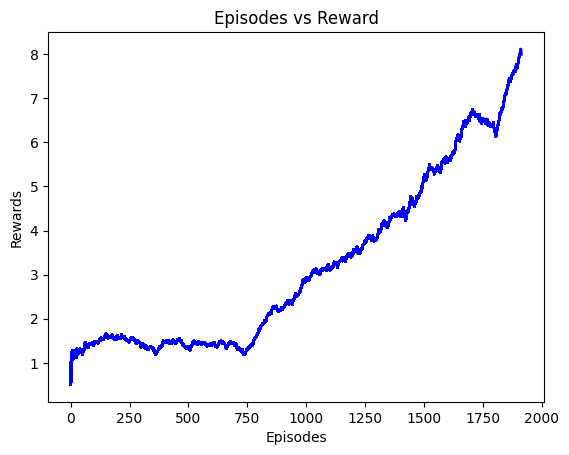

In [6]:
rewards, episodes = [], []
best_eval_reward = 0
for e in range(EPISODES):
    done = False
    score = 0

    history = np.zeros([5, 84, 84], dtype=np.uint8)
    step = 0
    d = False
    state = env.reset()
    next_state = state
    life = number_lives

    get_init_state(history, state)

    while not done:
        step += 1
        frame += 1

        # Perform a fire action if ball is no longer on screen to continue onto next life
        if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
            action = 0
        else:
            action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
            
        state = next_state
        next_state, reward, done, info = env.step(action + 1)
        
        frame_next_state = get_frame(next_state)
        history[4, :, :] = frame_next_state
        terminal_state = check_live(life, info['lives'])

        life = info['lives']
        r = np.clip(reward, -1, 1) 
        r = reward

        # Store the transition in memory 
        agent.memory.push(deepcopy(frame_next_state), action, r, terminal_state)
        # Start training after random sample generation
        if(frame >= train_frame):
            agent.train_policy_net(frame)
            # Update the target network only for Double DQN only
            if double_dqn and (frame % update_target_network_frequency)== 0:
                agent.update_target_net()
        score += reward
        history[:4, :, :] = history[1:, :, :]
            
        if done:
            evaluation_reward.append(score)
            rewards.append(np.mean(evaluation_reward))
            episodes.append(e)
            pylab.plot(episodes, rewards, 'b')
            pylab.xlabel('Episodes')
            pylab.ylabel('Rewards') 
            pylab.title('Episodes vs Reward')
            pylab.savefig("/content/save_graph/breakout_dqn.png") # save graph for training visualization
            
            # every episode, plot the play time
            print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon, "   steps:", step,
                  "   lr:", agent.optimizer.param_groups[0]['lr'], "    evaluation reward:", np.mean(evaluation_reward))

            # if the mean of scores of last 100 episode is bigger than 5 save model
            ### Change this save condition to whatever you prefer ###
            if (e%100) == 0:
              torch.save(agent.policy_net, "/content/save_model/breakout_dqn.pth")

            if np.mean(evaluation_reward) > 5 and np.mean(evaluation_reward) > best_eval_reward:
                torch.save(agent.policy_net, "/content/save_model/breakout_dqn.pth")
                best_eval_reward = np.mean(evaluation_reward)


# Visualize Agent Performance

BE AWARE THIS CODE BELOW MAY CRASH THE KERNEL IF YOU RUN THE SAME CELL TWICE.

Please save your model before running this portion of the code.

In [7]:
torch.save(agent.policy_net, "/content/save_model/breakout_dqn.pth")

In [8]:
# from gym.wrappers import Monitor
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64

from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display

# Displaying the game live
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % ("Agent Playing",step, info))
    plt.axis('off')

    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    
# Recording the game and replaying the game afterwards
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    
def wrap_env(env):
	env=RecordVideo(env, './video', episode_trigger = lambda episode_number: True)
	return env

In [12]:
display = Display(visible=0, size=(300, 200))
display.start()

# Load agent
# agent = Agent(action_size)

agent.load_policy_net("/content/save_model/breakout_dqn.pth")
agent.epsilon = 0.0 # Set agent to only exploit the best action

env = gym.make('BreakoutDeterministic-v4')
env = wrap_env(env)

done = False
score = 0
step = 0
state = env.reset()
next_state = state
life = number_lives
history = np.zeros([5, 84, 84], dtype=np.uint8)
get_init_state(history, state)

while not done:
    
    # Render breakout
    env.render()
#     show_state(env,step) # uncommenting this provides another way to visualize the game

    step += 1
    frame += 1

    # Perform a fire action if ball is no longer on screen
    if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
        action = 0
    else:
        action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
    state = next_state
    
    next_state, reward, done, info = env.step(action + 1)
        
    frame_next_state = get_frame(next_state)
    history[4, :, :] = frame_next_state
    terminal_state = check_live(life, info['lives'])
        
    life = info['lives']
    r = np.clip(reward, -1, 1) 
    r = reward

    # Store the transition in memory 
    agent.memory.push(deepcopy(frame_next_state), action, r, terminal_state)
    # Start training after random sample generation
    score += reward
    
    history[:4, :, :] = history[1:, :, :]
env.close()
show_video()
display.stop()

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment